This notebook shows how to run a simple 2D example of DIVA.<br>
The input files and the figures are created within the notebook.<br>
The reading/writing of input files is done through specific classes.

In [1]:
import os
import logging
import shutil
import subprocess
import numpy as np
import importlib
import diva_classes

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [38]:
importlib.reload(diva_classes)

<module 'diva_classes' from '/home/ctroupin/Projects/SeaDataCloud/Python/diva_classes.py'>

# Setup 

Adapt the path to the diva installation you want to work with.

In [32]:
divadir = "/home/ctroupin/Software/DIVA/diva-4.7.1"

## Logging configuration

In [9]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

## Directories

Create the directory and in the input files names.

In [10]:
DivaDirs = diva_classes.DivaDirectory(divadir)

DEBUG:root:/home/ctroupin/Software/DIVA/diva-4.7.1 exists
INFO:root:Diva binary directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/bin
INFO:root:Diva source directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/src/Fortan
INFO:root:Diva 2D directory: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped
INFO:root:Diva 4D directory: /home/ctroupin/Software/DIVA/diva-4.7.1/JRA4/Climatology
INFO:root:Diva 4D input directory: /home/ctroupin/Software/DIVA/diva-4.7.1/JRA4/Climatology/input


In [34]:
DivaFile = diva_classes.Diva2Dfiles(DivaDirs.diva2ddir)

INFO:root:Contour file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/coast.cont
INFO:root:Parameter file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/param.par
INFO:root:Data file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/data.dat
INFO:root:Valatxy file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord
INFO:root:Result file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/output/ghertonetcdf/results.nc
INFO:root:Mesh file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.22
INFO:root:Mesh topo file: /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.23


# Prepare the input files

## Contour

Create a sequence of points representing the contour (no crossing, no duplicate points, etc).<br>
Each coordinate (lon, lat) is defined as a [ndarray](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

In [12]:
lon = np.array([[0., 2., 2., 0.], [2.5, 6., 6., 2.5]])
lat = np.array([[0., 0., 4., 4.], [0., 0., 3., 3.]]) 

Create a **contour** object: 

In [13]:
contour2D = diva_classes.Diva2DContours(lon, lat)

and write its content to a file:

In [14]:
contour2D.write_to_file(DivaFile.contourfile)

DEBUG:root:Total number of contours: 2
DEBUG:root:Sub-contour no. 0 has 4 points
DEBUG:root:Sub-contour no. 1 has 4 points
INFO:root:Written contour file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/coast.cont


## Data

Create arrays of coordinates, values and optionnaly weights representing the data points.<br>
In this example we assume that all the data points have an identical weights.

In [15]:
x = np.array((1.2, 2., 3., 5.5))  
y = np.array((2.1, 3.5, 2., 0.2))
z = np.array((1., -2., 4, -1))

In [84]:
data2D = diva_classes.Diva2DData(x, y, z)

that we write to a file:

In [17]:
data2D.write_to_file(DivaFile.datafile)

INFO:root:Written data file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/data.dat


## Parameters

We need to set the parameters defining the domain and the analysis parameters.

In [18]:
xmin, ymin, nx, ny, dx, dy = 0.0, 0.0, 61, 81, 0.1, 0.05

In [19]:
CorrelationLength = 1.5
SignalToNoiseRatio = 0.5
VarianceBackgroundField = 1.0
ExclusionValue = -999.
iCoordChange = 0
iSpec = 11
iReg = 0

We create an object that stores all the parameter values:

In [20]:
parameters2D = diva_classes.Diva2DParameters(CorrelationLength, iCoordChange, iSpec, iReg, xmin, ymin, dx, dy, nx, ny,
                                ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField)

and we write them into a file:

In [21]:
parameters2D.write_to_file(DivaFile.parameterfile)

# Run Diva

Now that the input files have been created we can perform a Diva analysis.

## Mesh generation

In [22]:
logging.info("Generating finite element mesh")
subprocess.Popen("./divamesh", cwd=DivaDirs.diva2ddir, shell=True)

INFO:root:Generating finite element mesh


## Run the diva calculation

In [23]:
logging.info("Generating gridded field")
subprocess.Popen("./divacalc", cwd=DivaDirs.diva2ddir, shell=True)

INFO:root:Generating gridded field


# Time for some plots

In [24]:
import netCDF4
import matplotlib.pyplot as plt
%matplotlib inline

## Input files

Let's represent the osbervations, the grid and the contours.

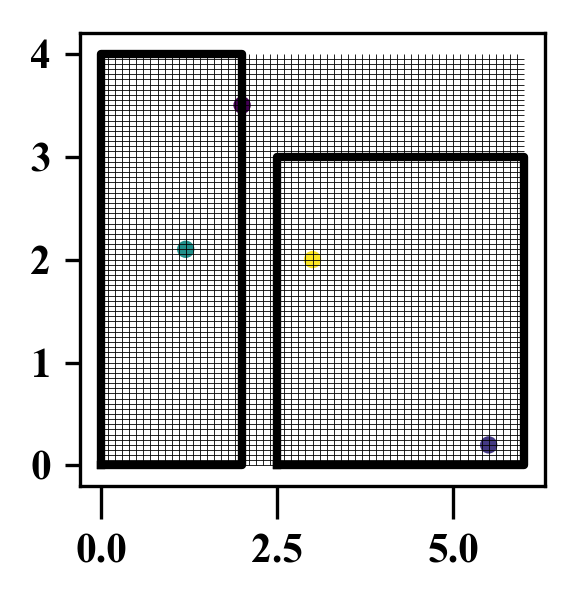

In [74]:
fig = plt.figure(figsize=(2, 2))
contour2D.add_to_plot(linewidth=2)
data2D.add_to_plot(s=10)
parameters2D.plot_outputgrid()

## Results 

The results are stored in a netCDF file that we can access using the resultfile property of DivaFile.<br>
The field is then added to the plot. In addition we can include the locations of the observations.

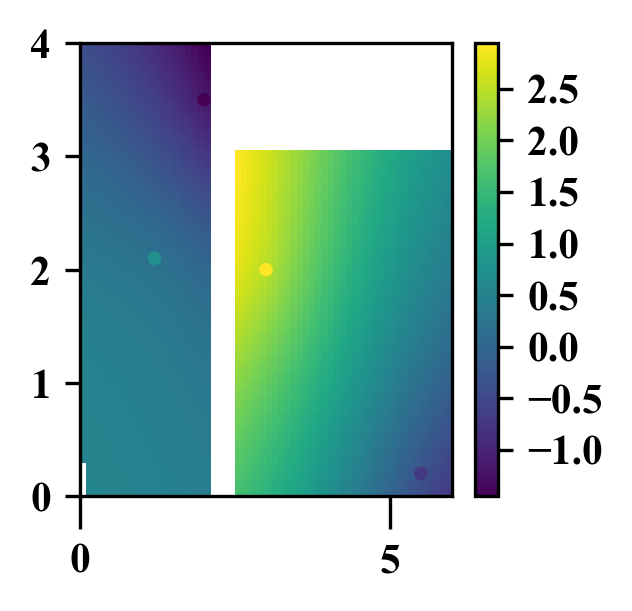

In [70]:
fig = plt.figure(figsize=(2, 2))
results2D = diva_classes.Diva2DResults(DivaFile.resultfile)
results2D.add_to_plot('result')
data2D.add_to_plot(cmap=plt.cm.viridis, s=5)

The error field is represented using a similar command:

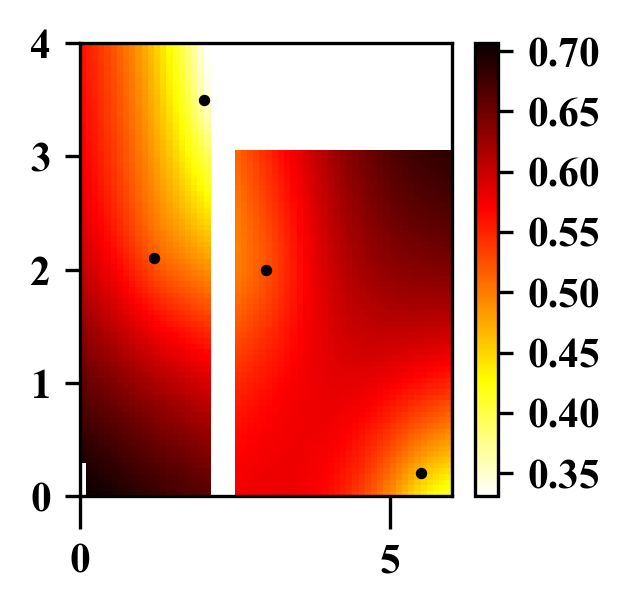

In [85]:
fig = plt.figure(figsize=(2, 2))
results2D.add_to_plot('error', cmap=plt.cm.hot_r)
data2D.add_positions_to_plot(s=3)

In [151]:
importlib.reload(diva_classes)

<module 'diva_classes' from '/home/ctroupin/Projects/SeaDataCloud/Python/diva_classes.py'>

## Finite-element mesh

In [152]:
mesh2D = diva_classes.Diva2DMesh(DivaFile.meshfile, DivaFile.meshtopofile)

INFO:root:Number of nodes: 325
INFO:root:Number of interfaces: 889
INFO:root:Number of elements: 566


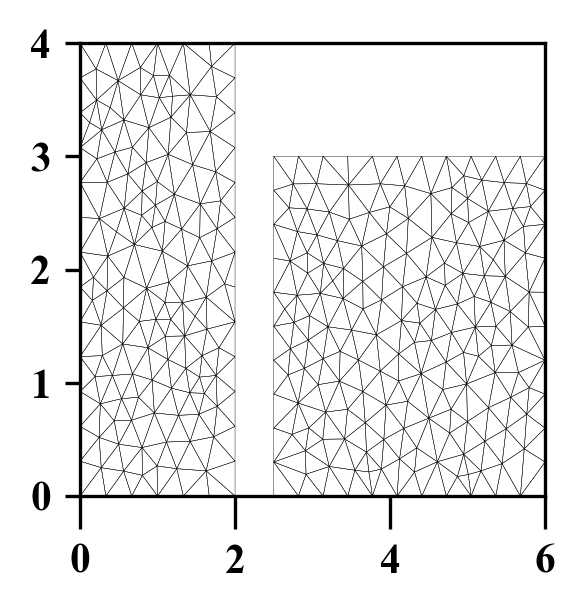

In [154]:
fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(111)
mesh2D.add_to_plot(ax, lw=0.1)